# Heat

In this example the laser-excitation of a sample `Structure` is shown.
It includes the actual absorption of the laser light as well as the transient temperature profile calculation.

## Setup

Do all necessary imports and settings.

In [1]:
import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim
import scipy.constants as constants
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib()  # use matplotlib with pint units

## Structure

Refer to the [structure-example](structure.ipynb) for more details.

In [2]:
O = ud.Atom('O')
Ti = ud.Atom('Ti')
Sr = ud.Atom('Sr')
Ru = ud.Atom('Ru')
Pb = ud.Atom('Pb')
Zr = ud.Atom('Zr')

In [3]:
# c-axis lattice constants of the two layers
c_STO_sub = 3.905*u.angstrom
c_SRO = 3.94897*u.angstrom
# sound velocities [nm/ps] of the two layers
sv_SRO = 6.312*u.nm/u.ps
sv_STO = 7.800*u.nm/u.ps

# SRO layer
prop_SRO = {}
prop_SRO['a_axis'] = c_STO_sub  # aAxis
prop_SRO['b_axis'] = c_STO_sub  # bAxis
prop_SRO['deb_Wal_Fac'] = 0  # Debye-Waller factor
prop_SRO['sound_vel'] = sv_SRO  # sound velocity
prop_SRO['opt_ref_index'] = 2.44+4.32j
prop_SRO['therm_cond'] = 5.72*u.W/(u.m*u.K)  # heat conductivity
prop_SRO['lin_therm_exp'] = 1.03e-5  # linear thermal expansion
prop_SRO['heat_capacity'] = '455.2 + 0.112*T - 2.1935e6/T**2'  # [J/kg K]

SRO = ud.UnitCell('SRO', 'Strontium Ruthenate', c_SRO, **prop_SRO)
SRO.add_atom(O, 0)
SRO.add_atom(Sr, 0)
SRO.add_atom(O, 0.5)
SRO.add_atom(O, 0.5)
SRO.add_atom(Ru, 0.5)

# STO substrate
prop_STO_sub = {}
prop_STO_sub['a_axis'] = c_STO_sub  # aAxis
prop_STO_sub['b_axis'] = c_STO_sub  # bAxis
prop_STO_sub['deb_Wal_Fac'] = 0  # Debye-Waller factor
prop_STO_sub['sound_vel'] = sv_STO  # sound velocity
prop_STO_sub['opt_ref_index'] = 2.1+0j
prop_STO_sub['therm_cond'] = 12*u.W/(u.m*u.K)  # heat conductivity
prop_STO_sub['lin_therm_exp'] = 1e-5  # linear thermal expansion
prop_STO_sub['heat_capacity'] = '733.73 + 0.0248*T - 6.531e6/T**2'  #  [J/kg K]

STO_sub = ud.UnitCell('STOsub', 'Strontium Titanate Substrate',
                      c_STO_sub, **prop_STO_sub)
STO_sub.add_atom(O, 0)
STO_sub.add_atom(Sr, 0)
STO_sub.add_atom(O, 0.5)
STO_sub.add_atom(O, 0.5)
STO_sub.add_atom(Ti, 0.5)

In [4]:
S = ud.Structure('Single Layer')
S.add_sub_structure(SRO, 100)  # add 100 layers of SRO to sample
S.add_sub_structure(STO_sub, 200)  # add 200 layers of STO substrate

## Initialize Heat

The `Heat` class requires a `Structure` object and a boolean `force_recalc` in order overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can using the boolean switch `progress_bar`.

In [5]:
h = ud.Heat(S, True)

h.save_data = False
h.disp_messages = True

print(h)

Heat simulation properties:

This is the current structure for the simulations:

Structure properties:

Name   : Single Layer
Thickness : 117.5897 nanometer
Roughness : 0.0000 nanometer
----
100 times Strontium Ruthenate: 39.4897 nanometer
200 times Strontium Titanate Substrate: 78.1000 nanometer
----
no substrate


Display properties:

================================  =======================================================
                       parameter  value
================================  =======================================================
                    force recalc  True
                 cache directory  ./
                display messages  True
                       save data  False
                    progress bar  True
              excitation fluence  [] mJ/cm²
                excitation delay  [0.0] ps
         excitation pulse length  [0.0] ps
           excitation wavelength  799.9999999999999 nm
                excitation theta  90.0 deg
excitation multilay

## Simple Excitation

In order to calculate the temperature of the sample after quasi-instantaneous (delta) photoexcitation the `excitation` must be set with the following parameters:
* `fluence`
* `delay_pump`
* `pulse_width`
* `multilayer_absorption`
* `wavelength`
* `theta`
* `backside`

The angle of incidence `theta` does change the footprint of the excitation on the sample for any type excitation.
The `wavelength` and `theta` angle of the excitation are also relevant if `multilayer_absorption = True`.
Otherwise the _Lambert_Beer_-law is used and its absorption profile is independent of `wavelength` and `theta`.
With `backside = True` the excitation is calculated to happen from the backside of the sample structure.  
__Note:__ the `fluence`, `delay_pump`, and `pulse_width` must be given as `array` or `list`.

The simulation requires also a `delay` array as temporal grid as well as an initial temperature `init_temp`.
The later can be either a scalar which is then the constant temperature of the whole sample structure, or the initial temperature can be an array of temperatures for each single layer in the structure.

In [6]:
h.excitation = {'fluence': [5]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [0]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 45*u.deg,
                'backside': False}

# when calculating the laser absorption profile using Lamber-Beer-law
# the opt_pen_depth must be set manually or calculated from the refractive index
SRO.set_opt_pen_depth_from_ref_index(800*u.nm)
STO_sub.set_opt_pen_depth_from_ref_index(800*u.nm)

# temporal and spatial grid
delays = np.r_[-10:200:0.1]*u.ps
_, _, distances = S.get_distances_of_layers()

### Laser Absorption Profile

Here the difference in the spatial laser absorption profile is shown between the multilayer absorption algorithm and the Lambert-Beer law.  
Note that Lambert-Beer does not include reflection of the incident light from the surface of the sample structure:

Absorption profile is calculated by multilayer formalism.
Total reflectivity of 56.1 % and transmission of 5.7 %.
Absorption profile is calculated by Lambert-Beer's law.


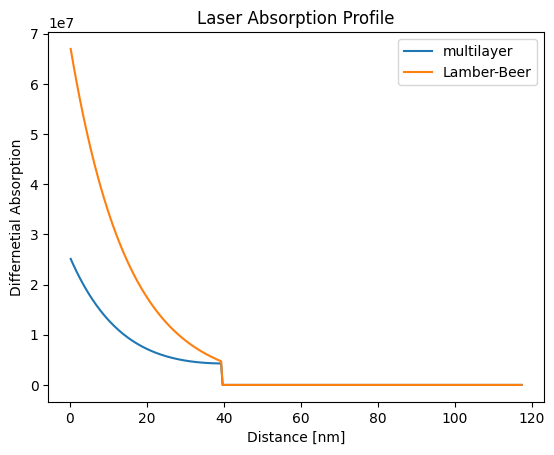

In [7]:
plt.figure()
dAdz, _, _, _ = h.get_multilayers_absorption_profile()
plt.plot(distances.to('nm'), dAdz, label='multilayer')
dAdz = h.get_Lambert_Beer_absorption_profile()
plt.plot(distances.to('nm'), dAdz, label='Lamber-Beer')
plt.legend()
plt.xlabel('Distance [nm]')
plt.ylabel('Differnetial Absorption')
plt.title('Laser Absorption Profile')
plt.show()

### Backside Excitation

The same calculation is repeated with the pump laser entering from the backside of the sample of the structure within the multilayer formalismus.  
The clear difference in absorbed energy stems from the significantly different reflectivity of the pump light for front- or backside excitation due to better or worse refractive-index matching.

Absorption profile is calculated by multilayer formalism.
Total reflectivity of 56.1 % and transmission of 5.7 %.
Absorption profile is calculated by multilayer formalism.
Backside excitation is enabled.
Total reflectivity of 28.2 % and transmission of 71.8 %.


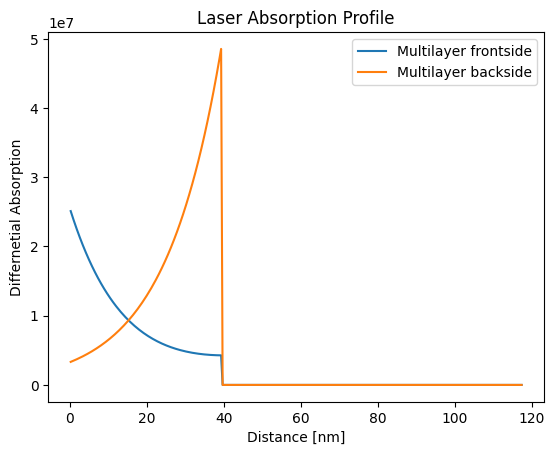

In [8]:
plt.figure()
dAdz, _, _, _ = h.get_multilayers_absorption_profile(backside=False)
plt.plot(distances.to('nm'), dAdz, label='Multilayer frontside')
dAdz, _, _, _ = h.get_multilayers_absorption_profile(backside=True)
plt.plot(distances.to('nm'), dAdz, label='Multilayer backside')
plt.legend()
plt.xlabel('Distance [nm]')
plt.ylabel('Differnetial Absorption')
plt.title('Laser Absorption Profile')
plt.show()

### Temperature Map

Calculating a tranient temperature map is only a one-line command:

In [9]:
temp_map, delta_temp = h.get_temp_map(delays, 300*u.K)

Surface incidence fluence scaled by factor 0.7071 due to incidence angle theta=45.00 deg
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 56.1 % and transmission of 5.7 %.
Elapsed time for _temperature_after_delta_excitation_: 0.018119 s
Elapsed time for _temp_map_: 0.079815 s


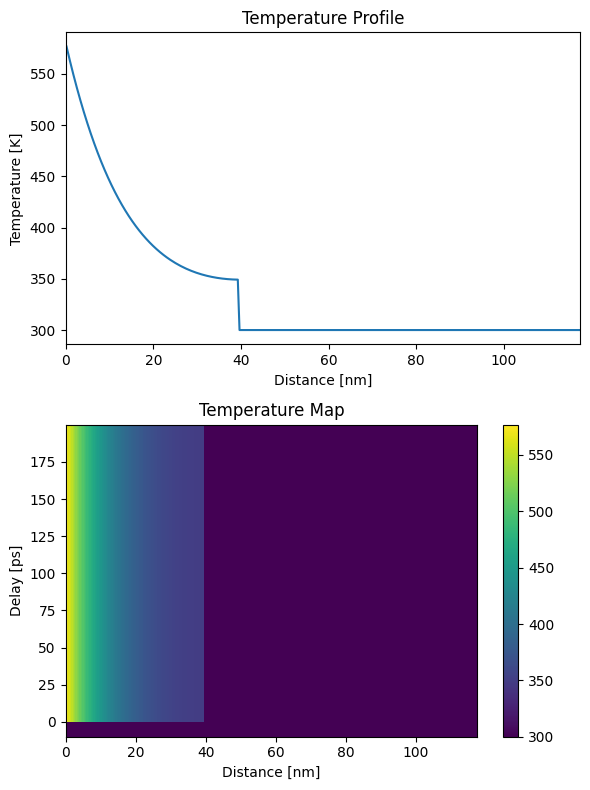

In [10]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, temp_map[101, :])
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Temperature [K]')
plt.title('Temperature Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map, shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map')

plt.tight_layout()
plt.show()

## Heat Diffusion

In order to enable heat diffusion the boolean switch `heat_diffusion` must be `True`.  
It is also reasonable to define a finte pump `pulse_width`.

In [11]:
# enable heat diffusion
h.heat_diffusion = True
# set the boundary conditions
h.boundary_conditions = {'top_type': 'isolator', 'bottom_type': 'isolator'}
# change only the pulse duration 
h.excitation = {'pulse_width':  [0.1]*u.ps}
# The resulting temperature profile is calculated in one line:
temp_map, delta_temp = h.get_temp_map(delays, 300*u.K)

Surface incidence fluence scaled by factor 0.7071 due to incidence angle theta=45.00 deg
Calculating _heat_diffusion_ for excitation 1:1 ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 56.1 % and transmission of 5.7 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_ with 1 excitation(s): 6.912568 s
Calculating _heat_diffusion_ without excitation...


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 7.145586 s
Elapsed time for _temp_map_: 14.211405 s


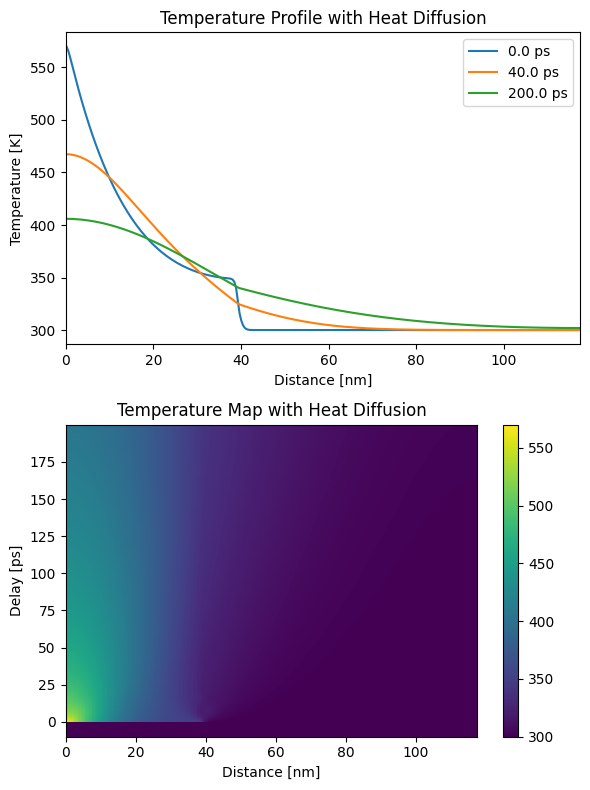

In [12]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, temp_map[101, :], label=np.round(delays[101]))
plt.plot(distances.to('nm').magnitude, temp_map[501, :], label=np.round(delays[501]))
plt.plot(distances.to('nm').magnitude, temp_map[-1, :], label=np.round(delays[-1]))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Temperature [K]')
plt.legend()
plt.title('Temperature Profile with Heat Diffusion')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map, shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map with Heat Diffusion')

plt.tight_layout()
plt.show()

### Heat Diffusion Parameters

For heat diffusion simulations various parameters for the underlying pdepe solver can be altered.

By default, the `backend` is set to `scipy` but can be switched to `matlab`.
Currently, the is no obvious reason to choose _MATLAB_ above _SciPy_.

Depending on the `backend` either the `ode_options` or `ode_options_matlab` can be configured and are directly handed to the actual solver.
Please refer to the documentation of the actual backend and solver and the __API documentation__ for more details.

The speed but also the result of the heat diffusion simulation strongly depends on the spatial grid handed to the solver.
By default, one spatial grid point is used for every `Layer` (`AmorphousLayer` or `UnitCell`) in the `Structure`.
The resulting `temp_map` will also always be interpolated in this spatial grid which is equivalent to the distance vector returned by `S.get_distances_of_layers()`.

As the solver for the heat diffusion usually suffers from large gradients, e.g. of thermal properties or initial temperatures, additional spatial grid points are added by default only for internal calculations.
The number of additional points (should be an odd number, default is 11) is set by:

In [13]:
h.intp_at_interface = 11

The internally used spatial grid can be returned by:

In [14]:
dist_interp, original_indicies = S.interp_distance_at_interfaces(h.intp_at_interface)

The internal spatial grid can also be given by hand, e.g. to realize logarithmic steps for rather large `Structure`:

In [15]:
h.distances = np.linspace(0, distances.magnitude[-1], 100)*u.m

As already shown above, the heat diffusion simulation supports also an top and bottom  boundary condition. The can have the types:
* `isolator`
* `temperature`
* `flux`

For the later types also a value must be provides:

In [16]:
h.boundary_conditions = {'top_type': 'temperature', 'top_value': 500*u.K,
                         'bottom_type': 'flux', 'bottom_value': 5e11*u.W/u.m**2}

print(h)

Heat simulation properties:

This is the current structure for the simulations:

Structure properties:

Name   : Single Layer
Thickness : 117.5897 nanometer
Roughness : 0.0000 nanometer
----
100 times Strontium Ruthenate: 39.4897 nanometer
200 times Strontium Titanate Substrate: 78.1000 nanometer
----
no substrate


Display properties:

================================  =======================================================
                       parameter  value
================================  =======================================================
                    force recalc  True
                 cache directory  ./
                display messages  True
                       save data  False
                    progress bar  True
              excitation fluence  [5.0] mJ/cm²
                excitation delay  [0.0] ps
         excitation pulse length  [0.1] ps
           excitation wavelength  800.0 nm
                excitation theta  45.0 deg
excitation multilayer absorp

In [17]:
# The resulting temperature profile is calculated in one line:
temp_map, delta_temp = h.get_temp_map(delays, 300*u.K)

Surface incidence fluence scaled by factor 0.7071 due to incidence angle theta=45.00 deg
Calculating _heat_diffusion_ without excitation...


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 0.766563 s
Calculating _heat_diffusion_ for excitation 1:1 ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 56.1 % and transmission of 5.7 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_ with 1 excitation(s): 0.587071 s
Calculating _heat_diffusion_ without excitation...


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 0.789711 s
Elapsed time for _temp_map_: 2.201782 s


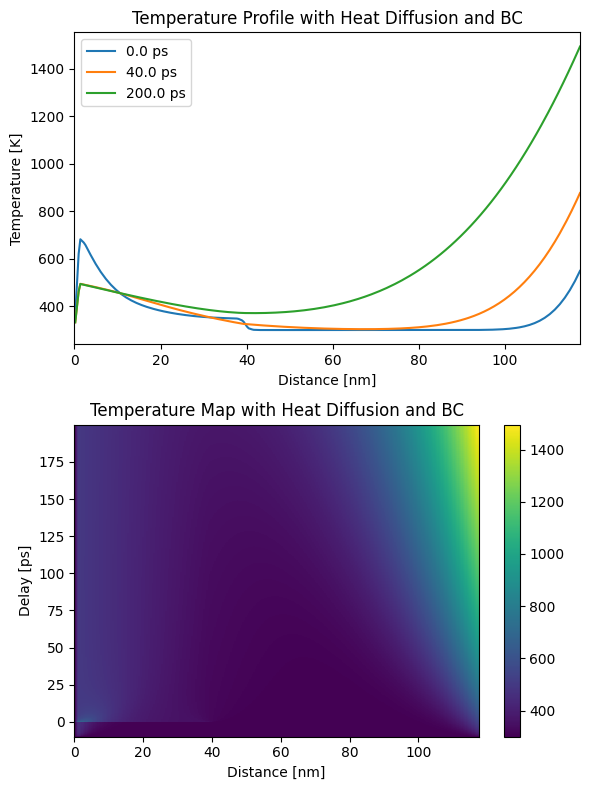

In [18]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, temp_map[101, :], label=np.round(delays[101]))
plt.plot(distances.to('nm').magnitude, temp_map[501, :], label=np.round(delays[501]))
plt.plot(distances.to('nm').magnitude, temp_map[-1, :], label=np.round(delays[-1]))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Temperature [K]')
plt.legend()
plt.title('Temperature Profile with Heat Diffusion and BC')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map, shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map with Heat Diffusion and BC')

plt.tight_layout()
plt.show()

## Multipulse Excitation

As already stated above, also multiple pulses of variable fluence, pulse width and, delay are possible.

The heat diffusion simulation automatically splits the calculation in parts with and without excitation and adjusts the initial temporal step width according to the pulse width.
Hence the solver does not miss any excitation pulses when adjusting its temporal step size.

The temporal laser pulse profile is always assumed to be Gaussian and the pulse width must be given as FWHM:

In [19]:
h.excitation = {'fluence': [5, 5, 5, 5]*u.mJ/u.cm**2,
                'delay_pump':  [0, 10, 20, 20.5]*u.ps,
                'pulse_width':  [0.1, 0.1, 0.1, 0.5]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 45*u.deg,
                'backside': False
               }

h.boundary_conditions = {'top_type': 'isolator', 'bottom_type': 'isolator'}

In [20]:
# The resulting temperature profile is calculated in one line:
temp_map, delta_temp = h.get_temp_map(delays, 300*u.K)

Surface incidence fluence scaled by factor 0.7071 due to incidence angle theta=45.00 deg
Calculating _heat_diffusion_ for excitation 1:4 ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 56.1 % and transmission of 5.7 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_ with 1 excitation(s): 0.678686 s
Calculating _heat_diffusion_ without excitation...


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 0.843477 s
Calculating _heat_diffusion_ for excitation 2:4 ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 56.1 % and transmission of 5.7 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_ with 1 excitation(s): 0.545883 s
Calculating _heat_diffusion_ without excitation...


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 0.706477 s
Calculating _heat_diffusion_ for excitation 3-4:4...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 56.1 % and transmission of 5.7 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_ with 2 excitation(s): 0.705586 s
Calculating _heat_diffusion_ without excitation...


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 0.792728 s
Elapsed time for _temp_map_: 4.473025 s


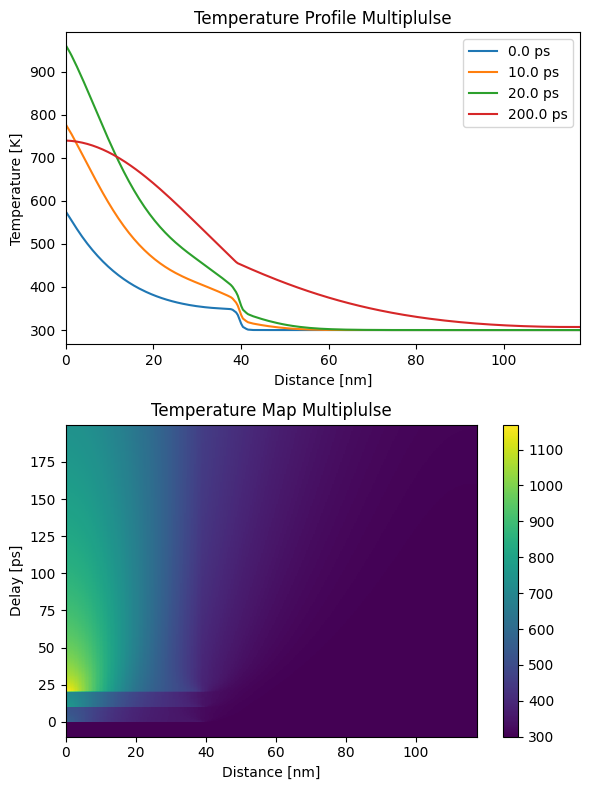

In [21]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, temp_map[101, :], label=np.round(delays[101]))
plt.plot(distances.to('nm').magnitude, temp_map[201, :], label=np.round(delays[201]))
plt.plot(distances.to('nm').magnitude, temp_map[301, :], label=np.round(delays[301]))
plt.plot(distances.to('nm').magnitude, temp_map[-1, :], label=np.round(delays[-1]))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Temperature [K]')
plt.legend()
plt.title('Temperature Profile Multiplulse')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map, shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Multiplulse')

plt.tight_layout()
plt.show()

## $N$-Temperature Model

The heat diffusion is also capable of simulating an _N_-temperature model which is often applied to empirically simulate the energy flow between _electrons_, _phonons_, and _spins_.
In order to run the _NTM_ all thermo-elastic properties must be given as a list of _N_ elements corresponding to different sub-systems.
The actual external laser-excitation is always set to happen within the __first__ sub-system, which is usually the electron-system.

In addition the `sub_system_coupling` must be provided in order to allow for energy-flow between the sub-systems.
`sub_system_coupling` is often set to a constant prefactor multiplied with the difference between the electronic and phononic temperatures, as in the example below. 
For sufficiently high temperatures, this prefactor also depdends on temperature. See [here](https://faculty.virginia.edu/CompMat/electron-phonon-coupling/) for an overview. 

In case the thermo-elastic parameters are provided as functions of the temperature $T$, the `sub_system_coupling` requires the temperature `T` to be a vector of all sub-system-temperatures which can be accessed in the function string via the underscore-notation. The `heat_capacity` and `lin_therm_exp` instead require the temperature `T` to be a scalar of only the current sub-system-temperature. For the `therm_cond` both options are available.

In [22]:
# update the relevant thermo-elastic properties of the layers in the sample
# structure
SRO.therm_cond = [0,
                  5.72*u.W/(u.m*u.K)]
SRO.lin_therm_exp = [1.03e-5,
                     1.03e-5]
SRO.heat_capacity = ['0.112*T',
                     '455.2 - 2.1935e6/T**2']
SRO.sub_system_coupling = ['5e17*(T_1-T_0)',
                           '5e17*(T_0-T_1)']

STO_sub.therm_cond = [0,
                      12*u.W/(u.m*u.K)]
STO_sub.lin_therm_exp = [1e-5,
                         1e-5]
STO_sub.heat_capacity = ['0.0248*T',
                         '733.73 - 6.531e6/T**2']
STO_sub.sub_system_coupling = ['5e17*(T_1-T_0)',
                               '5e17*(T_0-T_1)']

Number of subsystems changed from 1 to 2.
Number of subsystems changed from 1 to 2.


As no new `Structure` is build, the `num_sub_systems` must be updated by hand.
Otherwise this happens automatically.

In [23]:
S.num_sub_systems = 2

Set the excitation conditions:

In [24]:
h.excitation = {'fluence': [5]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [0.25]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 45*u.deg,
                'backside': False
               }

h.boundary_conditions = {'top_type': 'isolator', 'bottom_type': 'isolator'}

delays = np.r_[-5:15:0.01]*u.ps

In [25]:
# The resulting temperature profile is calculated in one line:
temp_map, delta_temp = h.get_temp_map(delays, 300*u.K)

Surface incidence fluence scaled by factor 0.7071 due to incidence angle theta=45.00 deg
Calculating _heat_diffusion_ for excitation 1:1 ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 56.1 % and transmission of 5.7 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_ with 1 excitation(s): 2.560416 s
Calculating _heat_diffusion_ without excitation...


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 2.828073 s
Elapsed time for _temp_map_: 5.497629 s


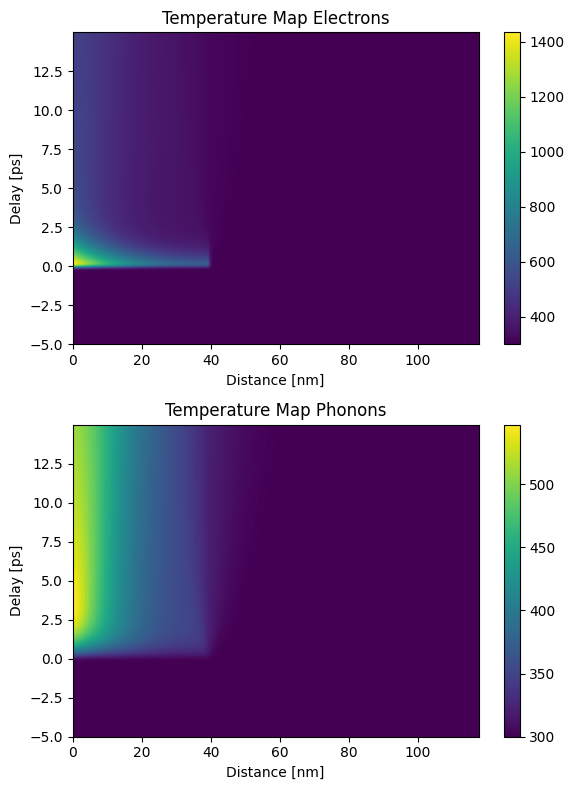

In [26]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 0],
               shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Electrons')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 1],
               shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Phonons')

plt.tight_layout()
plt.show()

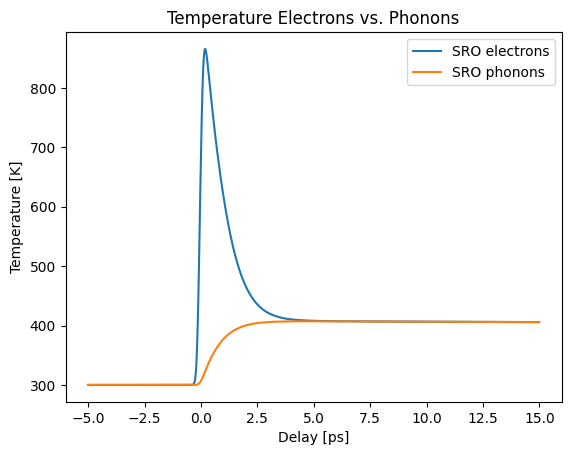

In [27]:
plt.figure()
select = S.get_all_positions_per_unique_layer()['SRO']
plt.plot(delays.to('ps'), np.mean(temp_map[:, select, 0], 1), label='SRO electrons')
plt.plot(delays.to('ps'), np.mean(temp_map[:, select, 1], 1), label='SRO phonons')
plt.ylabel('Temperature [K]')
plt.xlabel('Delay [ps]')
plt.legend()
plt.title('Temperature Electrons vs. Phonons')
plt.show()